In [1]:
import xarray as xr
from shapely.geometry import Point

import geopandas as gpd
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
import math
from multiprocess import Pool
import warnings
import matplotlib.pyplot as plt
# Suppress all warnings
warnings.filterwarnings('ignore', category=FutureWarning)
## my own directory
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")

In [2]:
params={     
    'axes.labelsize'  : '14',   
    'axes.titlesize'  : '14',  
    'xtick.labelsize' :'14',
    'ytick.labelsize' :'14',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [3]:
## daily
df = pd.read_csv("./data/BoM_daily_stations_1960_both.csv")
## mannually remove some faulty stations
# df = df[(df['ID'] != 40592) & (df['ID'] != 40593) & (df['ID'] != 58090) & (df["End_Year"]>=1960)]
# daily_lat = []
# daily_lon = []
# for i in range(0, len(df)):
#     daily_lat.append(df["Latitude"].iloc[i])
#     daily_lon.append(df["Longitude"].iloc[i])

In [4]:
percentile = 0.90

## make a dataset for percentile first

In [5]:
# Dictionary to store 90th percentile values for each month
stn_bom_p90 = {"ID": [], "Jan": [], "Feb": [], "Mar": [], "Apr": [], "May": [], "Jun": [],
               "Jul": [], "Aug": [], "Sep": [], "Oct": [], "Nov": [], "Dec": []}

faulty_stn = []

start = "1960-01-01"
end = "1973-12-31" # "1993-12-31" 

for stn_id in tqdm(df["ID"], leave=True, position=0):
    bom_id = str(stn_id).zfill(6)
    
    try:
        ds = xr.open_dataset(f"/g/data/k10/dl6968/BoM_daily_station/prcp_pc_ts_qc/{bom_id}.nc")
    except:
        faulty_stn.append(stn_id)
        continue
    ds = ds.assign_coords(month=ds['time'].dt.month)
    precip = ds["prcp"].sel(time=slice(start,end))
    rainy_days = precip.where(precip > 1, drop=True)
    
    
    # If there are no rainy days, store -1 for all months
    if len(rainy_days) == 0:
        stn_bom_p90["ID"].append(stn_id)
        for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]:
            stn_bom_p90[month].append(np.nan)
    else:
        stn_bom_p90["ID"].append(stn_id)
        p90_monthly = rainy_days.groupby('month').quantile(percentile, dim='time', skipna=True)
        # Store results for each month
        for month_num, month_name in enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], start=1):
            try:
                stn_bom_p90[month_name].append(p90_monthly.sel(month=month_num).values)
            except:
                stn_bom_p90[month_name].append(np.nan)

    ds.close()


100%|██████████| 2070/2070 [03:58<00:00,  8.68it/s]


In [6]:
df_p90_pre = pd.DataFrame.from_dict(stn_bom_p90)

In [7]:
df_p90_pre.to_csv("./data/BoM_stn_p90_1960-1973.csv")

In [8]:
# Dictionary to store 90th percentile values for each month
stn_bom_p90 = {"ID": [], "Jan": [], "Feb": [], "Mar": [], "Apr": [], "May": [], "Jun": [],
               "Jul": [], "Aug": [], "Sep": [], "Oct": [], "Nov": [], "Dec": []}

faulty_stn = []

start = "2010-01-01"#"1992-01-01"
end = "2023-12-31"

for stn_id in tqdm(df["ID"], leave=True, position=0):
    bom_id = str(stn_id).zfill(6)
    
    try:
        ds = xr.open_dataset(f"/g/data/k10/dl6968/BoM_daily_station/prcp_pc_ts_qc/{bom_id}.nc")
    except:
        faulty_stn.append(stn_id)
        continue
    ds = ds.assign_coords(month=ds['time'].dt.month)
    precip = ds["prcp"].sel(time=slice(start,end))
    rainy_days = precip.where(precip > 1, drop=True)
    
    
    # If there are no rainy days, store -1 for all months
    if len(rainy_days) == 0:
        stn_bom_p90["ID"].append(stn_id)
        for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]:
            stn_bom_p90[month].append(np.nan)
    else:
        stn_bom_p90["ID"].append(stn_id)
        p90_monthly = rainy_days.groupby('month').quantile(percentile, dim='time', skipna=True)
        # Store results for each month
        for month_num, month_name in enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], start=1):
            try:
                stn_bom_p90[month_name].append(p90_monthly.sel(month=month_num).values)
            except:
                stn_bom_p90[month_name].append(np.nan)

    ds.close()


100%|██████████| 2070/2070 [01:02<00:00, 32.90it/s]


In [9]:
df_p90_post = pd.DataFrame.from_dict(stn_bom_p90)
df_p90_post.to_csv("./data/BoM_stn_p90_2010-2023.csv")

In [10]:
def calc_season_p90(df):
    df["DJF"] = np.nansum(np.array([df["Dec"].values + df["Jan"].values + df["Feb"].values]),axis=0)/3
    df["MAM"] = np.nansum(np.array([df["Mar"].values + df["Apr"].values + df["May"].values]),axis=0)/3
    df["JJA"] = np.nansum(np.array([df["Jun"].values + df["Jul"].values + df["Aug"].values]),axis=0)/3
    df["SON"] = np.nansum(np.array([df["Sep"].values + df["Oct"].values + df["Nov"].values]),axis=0)/3
    return df

In [12]:
df_p90_post = calc_season_p90(df_p90_post)
df_p90_pre = calc_season_p90(df_p90_pre)

## NRM regions

In [13]:
# Load the shapefile of regions
regions_gdf = gpd.read_file("/g/data/k10/dl6968/Rain_gauge_scale/data/NRM_modified/NRM_modified.shp")  # Replace with your shapefile path

In [14]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
stations_with_regions = gpd.sjoin(stations_gdf, regions_gdf, how="left", predicate="within")


In [15]:
WT_stn = stations_with_regions[stations_with_regions["code"]=="WT"]
SSWFW_stn = stations_with_regions[stations_with_regions["code"]=="SSWFW"] # SFW
SSWFE_stn = stations_with_regions[stations_with_regions["code"]=="SSWFE"] # SFE
SSVW_stn = stations_with_regions[stations_with_regions["code"]=="SSVW"] # VICW
SSVE_stn = stations_with_regions[stations_with_regions["code"]=="SSVE"] # VICE
SSTW_stn = stations_with_regions[stations_with_regions["code"]=="SSTW"] # TASW
SSTE_stn = stations_with_regions[stations_with_regions["code"]=="SSTE"] # TASE
RW_stn = stations_with_regions[stations_with_regions["code"]=="RW"]
RE_stn = stations_with_regions[stations_with_regions["code"]=="RE"]
MNW_stn = stations_with_regions[stations_with_regions["code"]=="MNW"]
MNE_stn = stations_with_regions[stations_with_regions["code"]=="MNE"]
MB_stn = stations_with_regions[stations_with_regions["code"]=="MB"]
ECS_stn = stations_with_regions[stations_with_regions["code"]=="ECS"]
ECN_stn = stations_with_regions[stations_with_regions["code"]=="ECN"]
CS_stn = stations_with_regions[stations_with_regions["code"]=="CS"]

In [16]:
def nrm_season_weighted(df_in, id_df):
    djf_scale = np.array([df_in[df_in["ID"]==spec_id]["DJF"].values[0] for spec_id in id_df])
    mam_scale = np.array([df_in[df_in["ID"]==spec_id]["MAM"].values[0] for spec_id in id_df])
    jja_scale = np.array([df_in[df_in["ID"]==spec_id]["JJA"].values[0] for spec_id in id_df])
    son_scale = np.array([df_in[df_in["ID"]==spec_id]["SON"].values[0] for spec_id in id_df])
    
    djf_valid = djf_scale[~np.isnan(djf_scale)]
    mam_valid = mam_scale[~np.isnan(mam_scale)]
    jja_valid = jja_scale[~np.isnan(jja_scale)]
    son_valid = son_scale[~np.isnan(son_scale)]
    
    return [djf_valid, mam_valid, jja_valid, son_valid]

In [18]:
nrm_pre_p90_dict = {}
nrm_post_p90_dict = {}
for regions in stations_with_regions["code"].unique()[:-1]:
    nrm_pre_p90_dict[regions] = nrm_season_weighted(df_p90_pre,stations_with_regions[stations_with_regions["code"]==regions]["ID"])
    nrm_post_p90_dict[regions] = nrm_season_weighted(df_p90_post,stations_with_regions[stations_with_regions["code"]==regions]["ID"])

In [19]:
## change the keys so I can remember them easily
for nrm_dicts in [nrm_pre_p90_dict, nrm_post_p90_dict]:
    nrm_dicts["SFW"] = nrm_dicts.pop("SSWFW")
    nrm_dicts["SFE"] = nrm_dicts.pop("SSWFE")
    nrm_dicts["VICW"] = nrm_dicts.pop("SSVW")
    nrm_dicts["VICE"] = nrm_dicts.pop("SSVE")
    nrm_dicts["TASW"] = nrm_dicts.pop("SSTW")
    nrm_dicts["TASE"] = nrm_dicts.pop("SSTE")

In [20]:
rcolors = [
     "blue",  "lightgray",  "salmon",
     "orange",  "black",  "fuchsia",
     "navy",  "lightgreen", "maroon",
     "red",  "cyan",  "dodgerblue",
     "tan", "darkgreen",  "darkcyan"
]
def index_to_letter_lower(index):
    return chr(96 + index)

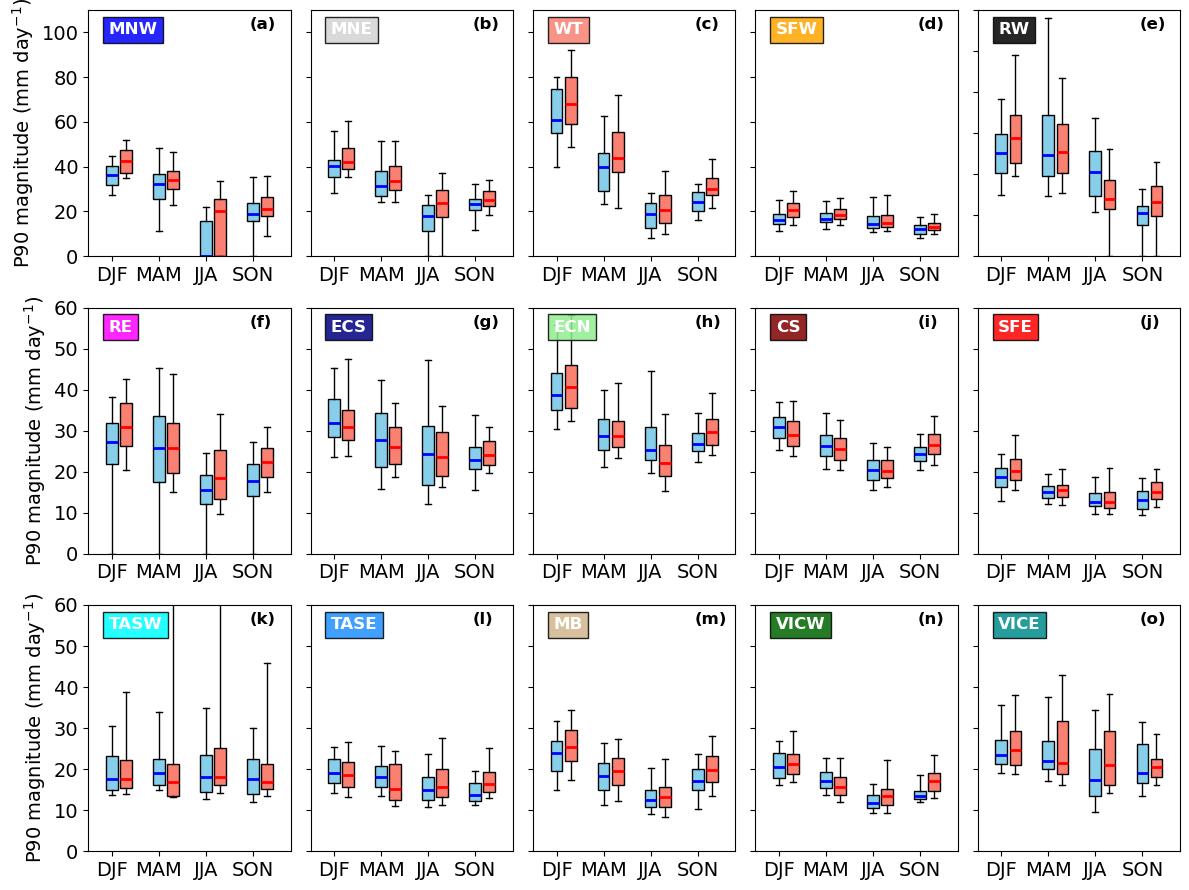

In [21]:
plt.figure(figsize=(12,9))
# Define positions for each group
positions_pre = [1, 2, 3, 4]
# Shift the positions slightly for the second set
shift = 0.3
positions_post = [x + shift for x in positions_pre]
for i, region in enumerate(["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]):
    ax = plt.subplot(3,5,i+1)
    pre_data = [data[~np.isnan(data)] for data in nrm_pre_p90_dict[region]]
    # if region=="MNW":
    #     pre_data[2] = []
    #     pre_data[3] = []
    bp_pre = plt.boxplot(pre_data, widths=0.25,whis=(5,95),
                         positions=positions_pre, showfliers=False,patch_artist=True)
    for box in bp_pre['boxes']:
        box.set_facecolor("skyblue")
    for median in bp_pre['medians']:
        median.set_color("blue")  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
    
    post_data = [data[~np.isnan(data)] for data in nrm_post_p90_dict[region]]
    # if region=="MNW":
    #     post_data[2] = []
    #     post_data[3] = []
    bp_post = plt.boxplot(post_data, widths=0.25,whis=(5,95),
                          positions=positions_post,showfliers=False,patch_artist=True)
    # Change the box color for post data
    for box in bp_post['boxes']:
        box.set_facecolor("salmon")
    for median in bp_post['medians']:
        median.set_color("red")  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
    plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])
    if i % 5 == 0:
            plt.ylabel("P90 magnitude (mm day$^{-1}$)")
    else:
        ax.set_yticklabels([])
    # plt.ylabel("Length scale (km)")
    ax.text(0.1, 0.95, region, transform=ax.transAxes, fontsize=12, color="w", fontweight="bold",
                 verticalalignment='top', bbox=dict(facecolor=rcolors[i], alpha=0.85))
    ax.text(0.8, 0.97, f"({index_to_letter_lower(i+1)})", transform=ax.transAxes, fontsize=12, color="k", fontweight="bold",
                 verticalalignment='top' )
    # plt.title(region)
    plt.ylim([0,110])
    if i +1<5:
         plt.ylim([0,110])
    else:
        plt.ylim([0,60])
plt.tight_layout()
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_trend_p90_boxplot_nodrought.png", dpi=200, bbox_inches="tight")

In [22]:
import scipy.stats as stats
from matplotlib.lines import Line2D
import seaborn as sns

In [23]:
stats_dict = {}
diff_dict = {}
region_list = ["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]
for region in region_list:
    stats_dict[region] = np.zeros(4).astype(float)
    diff_dict[region] = np.zeros(4).astype(float)
    for i in range(0,4):
        
        stats_dict[region][i] = stats.median_test(nrm_pre_p90_dict[region][i], nrm_post_p90_dict[region][i])[1]
        diff_dict[region][i] = np.nanmedian(nrm_post_p90_dict[region][i]) - np.nanmedian(nrm_pre_p90_dict[region][i]) 
        
pvalue_diff = np.array([np.array(stats_dict[region]) for region in region_list])
diff_val = np.array([np.array(diff_dict[region]) for region in region_list])

In [24]:
import cmcrameri.cm as cmc
from matplotlib.colors import LinearSegmentedColormap


In [25]:
def make_center_white(cmap_name='bwr', ncolors=256, white_at=0.5):
    """Modify an existing diverging colormap so the center color is white."""
    base = plt.get_cmap(cmap_name, ncolors)
    colors = base(np.linspace(0, 1, ncolors))
    
    # Set the center color to white
    center_index = int(ncolors * white_at)
    colors[center_index] = [1, 1, 1, 1]  # RGBA for white
    
    # Optional: Smooth transition near white
    # You can adjust colors[center_index ± 1 or 2] to also fade into white
    
    new_cmap = LinearSegmentedColormap.from_list(f"{cmap_name}_white", colors)
    return new_cmap

# Create the modified colormap
custom_cmap = make_center_white('cmc.vik_r')

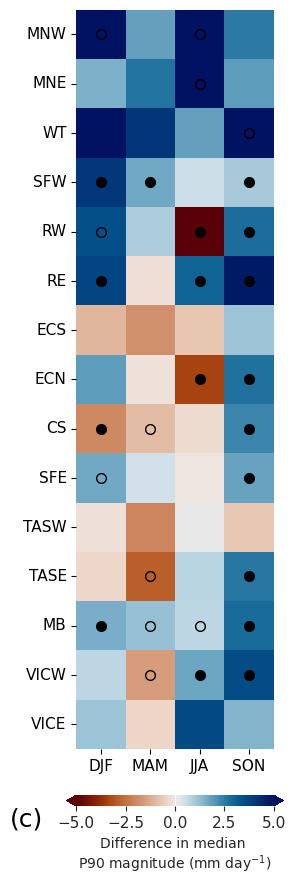

In [26]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(111)
with sns.axes_style("white"):
   # Disable the colorbar for each heatmap (cbar=False)
   g1 = sns.heatmap(diff_val,  square=True,
                        vmin=-5, vmax=5, cmap=custom_cmap, cbar=True,
                    cbar_kws={'extend': 'both','shrink': 0.7,"pad":0.05,"orientation":"horizontal"})
   
cbar = g1.collections[0].colorbar
cbar.set_label('Difference in median \nP90 magnitude (mm day$^{-1})$',fontsize=10)
cbar.ax.tick_params(labelsize=11)
ax.set_xticks(np.arange(4) + 0.5)
_ = ax.set_xticklabels(["DJF","MAM","JJA", "SON"], rotation=0,fontsize=11)
_ = ax.set_yticklabels(region_list, rotation=0,fontsize=11)
for i in range(pvalue_diff.shape[0]):
      for j in range(pvalue_diff.shape[1]):
         p = pvalue_diff[i, j]
         if p < 0.001:
               # Solid black dot
               markerfacecolor = "black"
               markeredgecolor = "black"
         elif p < 0.01:
               # Hollow dot (no face color, just edge)
               markerfacecolor = "none"
               markeredgecolor = "black"
         else:
               continue  # Do nothing if p-value doesn't meet criteria.
         # Plot the marker at the center of cell (i, j)
         ax.plot(j + 0.5, i + 0.5, marker='o', markersize=7,
                  markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
           markeredgecolor='black', markersize=8, label='p < 0.001'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
           markeredgecolor='black', markersize=8, label='p < 0.01')
]

# Add a common legend to the figure.
# Adjust bbox_to_anchor and loc as needed.
# fig.legend(handles=legend_elements, loc='lower left', ncol=2, bbox_to_anchor=(0.5, 0.12))
plt.gcf().text(0.1, 0.2,"(c)", fontsize=18)
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_trend_heatmap_p90_nodrought.png", dpi=200, bbox_inches="tight")